# **Preparing Dependancies**

In [1]:
# Install dan Update library agar tidak ada error 'cached_download'
!pip install -U diffusers huggingface_hub transformers accelerate -q

# --- WAJIB RESTART SESSION DI MENU RUNTIME SETELAH CELL INI SELESAI ---

In [2]:
import torch
import gc
from google.colab import userdata
from huggingface_hub import login
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipeline
import matplotlib.pyplot as plt
from PIL import Image

# Login otomatis menggunakan Secrets
login(userdata.get('HF_TOKEN'))

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


# **Kriteria 1: Melakukan Image Generation dari Teks (Text-to-Image)**

## **Load Base Pipeline Model**

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"

# Load model utama (Text-to-Image)
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")

# Re-use komponen untuk Img2Img dan Inpainting tanpa download ulang
pipe_img2img = StableDiffusionImg2ImgPipeline(
    vae=pipe.vae, text_encoder=pipe.text_encoder, tokenizer=pipe.tokenizer,
    unet=pipe.unet, scheduler=pipe.scheduler, feature_extractor=pipe.feature_extractor,
    safety_checker=pipe.safety_checker
).to("cuda")

pipe_inpaint = StableDiffusionInpaintPipeline(
    vae=pipe.vae, text_encoder=pipe.text_encoder, tokenizer=pipe.tokenizer,
    unet=pipe.unet, scheduler=pipe.scheduler, feature_extractor=pipe.feature_extractor,
    safety_checker=pipe.safety_checker
).to("cuda")

# Definisikan LogicHelper untuk membantu fungsi generate
class LogicHelper:
    def generate_advanced_image(self, pipe, prompt, negative_prompt=None, seed=None, num_inference_steps=30, guidance_scale=7.5):
        generator = torch.Generator(device=pipe.device).manual_seed(seed) if seed is not None else None
        return pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=generator).images

logic = LogicHelper()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## **Generate Image**


  0%|          | 0/50 [00:00<?, ?it/s]

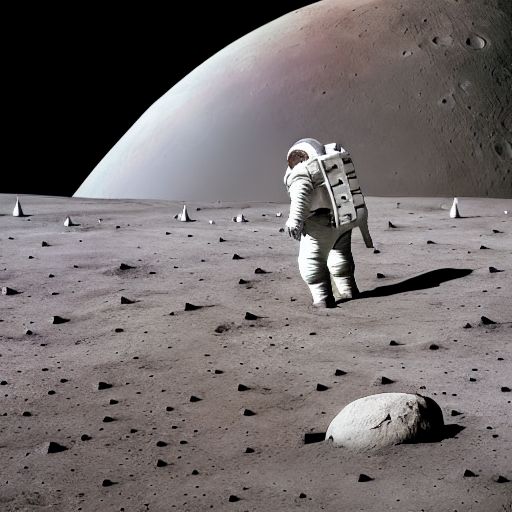

In [4]:
# Definisi helper karena file logic.py tidak ada
class LogicHelper:
    def generate_simple_image(self, pipe, prompt, negative_prompt=None, seed=None):
        generator = torch.Generator(device=pipe.device).manual_seed(seed) if seed is not None else None
        output = pipe(prompt=prompt, negative_prompt=negative_prompt, generator=generator)
        return output.images

logic = LogicHelper()

# Parameter gambar
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
negative_prompt = "blurry, low quality, distorted"
seed = 222

# Generate
image = logic.generate_simple_image(pipe, prompt, negative_prompt=negative_prompt, seed=seed)[0]
display(image)

## **Generate Image with Hyperparameter Configuration**

  0%|          | 0/50 [00:00<?, ?it/s]

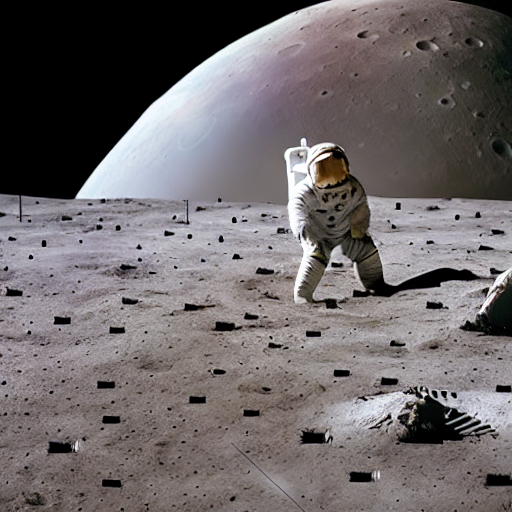

In [5]:
# Tambahkan fungsi advanced ke dalam class logic yang sudah ada
def generate_advanced_image(self, pipe, prompt, negative_prompt=None, seed=None, num_inference_steps=30, guidance_scale=7.5):
    generator = torch.Generator(device=pipe.device).manual_seed(seed) if seed is not None else None
    output = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps,
                  guidance_scale=guidance_scale, generator=generator)
    return output.images

# Tempelkan fungsi baru ke objek logic
LogicHelper.generate_advanced_image = generate_advanced_image

# Eksekusi dengan hyperparameter
image = logic.generate_advanced_image(
    pipe, prompt, negative_prompt=negative_prompt, seed=seed,
    num_inference_steps=50, guidance_scale=9.0
)[0]
display(image)

## **Guidance Scale Comparison**

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

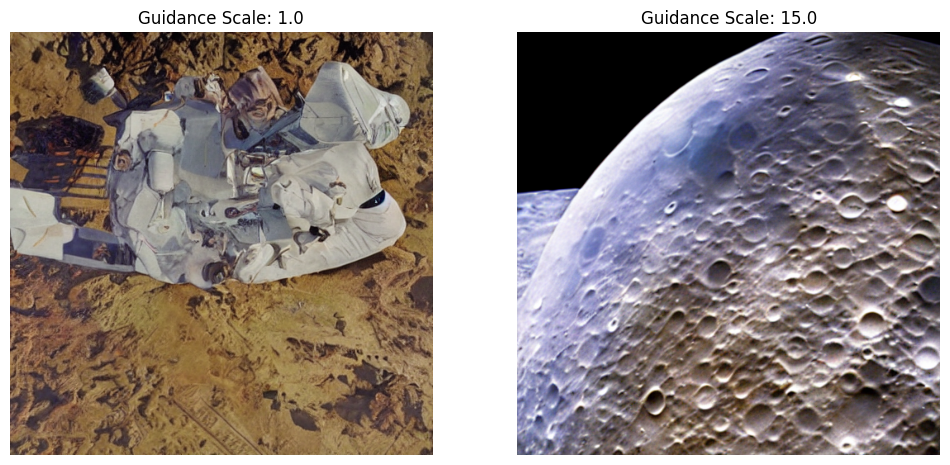

In [6]:
import matplotlib.pyplot as plt

# 1. Setting parameter
scales = [1.0, 15.0] # Membandingkan scale sangat rendah vs sangat tinggi
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
negative_prompt = "blurry, low quality"
images_scale = []

# 2. Loop generation
for s in scales:
    # Memanggil fungsi logic helper (pastikan class LogicHelper sudah di-run di atas)
    img = logic.generate_advanced_image(
        pipe,
        prompt,
        negative_prompt=negative_prompt,
        seed=222,           # Seed harus sama untuk perbandingan yang adil
        guidance_scale=s,   # Variabel scale yang diuji
        num_inference_steps=30
    )[0]
    images_scale.append(img)

# 3. Visualisasi berdampingan
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for i, ax in enumerate(axes):
    ax.imshow(images_scale[i])
    ax.set_title(f"Guidance Scale: {scales[i]}")
    ax.axis('off')
plt.show()

### Guidance Scale Explanation:

*   **Gambar dengan "Scale" Rendah:**
Gambar dengan "Scale" Rendah (1.0):
Gambar tampak sangat abstrak, kurang detail, dan seringkali tidak menyerupai deskripsi astronot atau bumi dalam prompt. Karakteristik visualnya memiliki variasi yang acak dan terlihat pudar karena AI diberikan kebebasan penuh tanpa dipaksa mengikuti instruksi teks secara ketat.

*   **Gambar dengan "Scale" Tinggi:**
Gambar terlihat sangat patuh pada prompt dengan detail yang jauh lebih tegas dan tajam pada subjek astronot serta planet bumi. Perbedaannya sangat kontras dibandingkan scale rendah; warna tampak lebih jenuh (vibrant) dan garis objek lebih jelas, meskipun jika terlalu tinggi kadang warna bisa terlihat terlalu "tajam" atau sedikit terbakar (oversaturated).



## **Inference Steps Comparison**

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

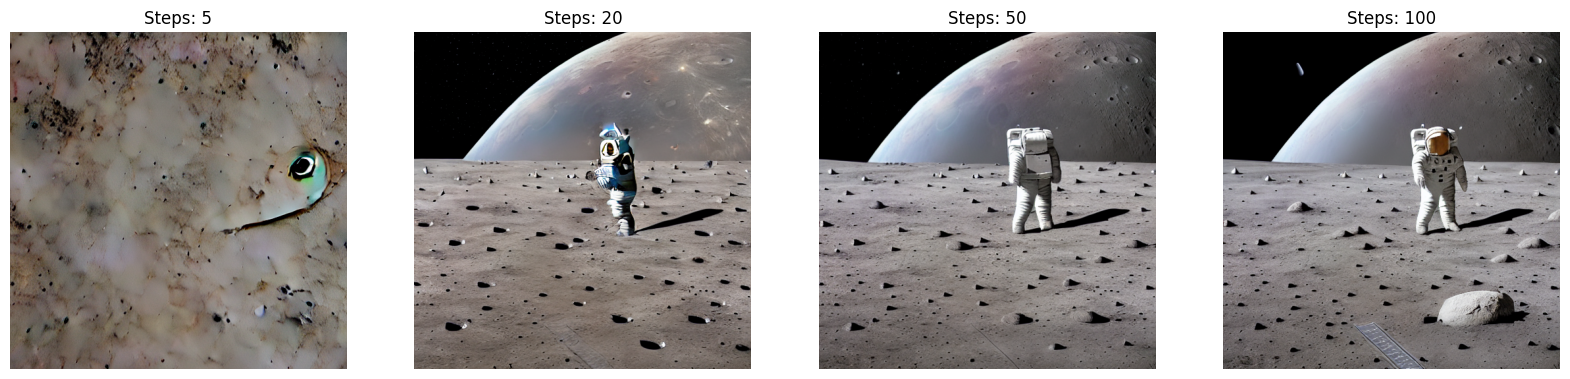

In [7]:
import matplotlib.pyplot as plt

# 1. Konfigurasi Experiment
steps_li = [5, 20, 50, 100]
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
negative_prompt = "blurry, low quality"
images_steps = []

# 2. Loop Generation berdasarkan jumlah steps
for s in steps_li:
    # Menggunakan seed yang sama (222) agar perbandingan konsisten
    img = logic.generate_advanced_image(
        pipe,
        prompt,
        negative_prompt=negative_prompt,
        seed=222,
        num_inference_steps=s, # Variabel steps yang diuji
        guidance_scale=7.5
    )[0]
    images_steps.append(img)

# 3. Visualisasi Hasil
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(images_steps[i])
    ax.set_title(f"Steps: {steps_li[i]}")
    ax.axis('off')
plt.show()

### **Inference Step Explanation:**

*   **Gambar dengan "Step" Rendah:**  
*Gambar yang dihasilkan pada jumlah step rendah cenderung tampak sangat buram, kurang detail, dan seringkali masih dipenuhi oleh noise (bintik-bintik acak) atau artefak visual yang mengganggu. Hal ini terjadi karena proses denoising (pembersihan gambar) belum selesai dilakukan oleh model, sehingga struktur objek (seperti astronot) belum terbentuk secara tajam dan proporsional.*

*   **Gambar dengan "Step" Tinggi:**  
*Gambar terlihat jauh lebih tajam, jernih, dan memiliki detail yang sangat kaya pada tekstur (seperti detail pada baju astronot atau kawah bulan). Perbedaan utama dibandingkan step rendah adalah kehalusan gradasi warna, hilangnya artefak visual, serta stabilitas visual yang lebih baik karena model memiliki lebih banyak iterasi untuk menyempurnakan setiap bagian gambar hingga mencapai hasil akhir yang matang.*

## **Batch Inference from One Prompt**

  0%|          | 0/30 [00:00<?, ?it/s]

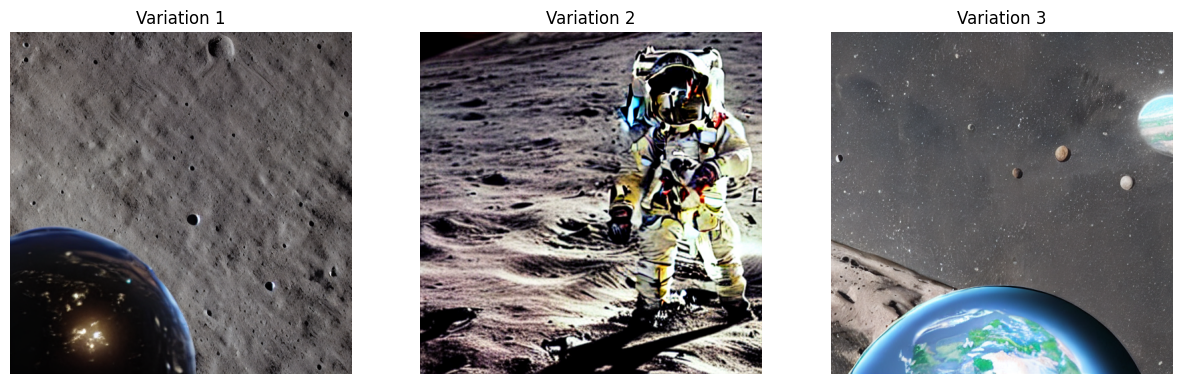

In [8]:
# 1. Tentukan parameter
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
num_images = 3  # Jumlah gambar yang ingin dihasilkan sekaligus

# 2. Jalankan inference dengan parameter num_images_per_prompt
# Kita menggunakan 'pipe' langsung karena fungsi batch biasanya sudah bawaan pipeline
output_images = pipe(
    prompt=prompt,
    num_images_per_prompt=num_images,
    num_inference_steps=30,
    guidance_scale=7.5
).images

# 3. Tampilkan semua hasil gambar dalam satu baris
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(output_images[i])
    ax.set_title(f"Variation {i+1}")
    ax.axis('off')
plt.show()

## **Load Scheduler**

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

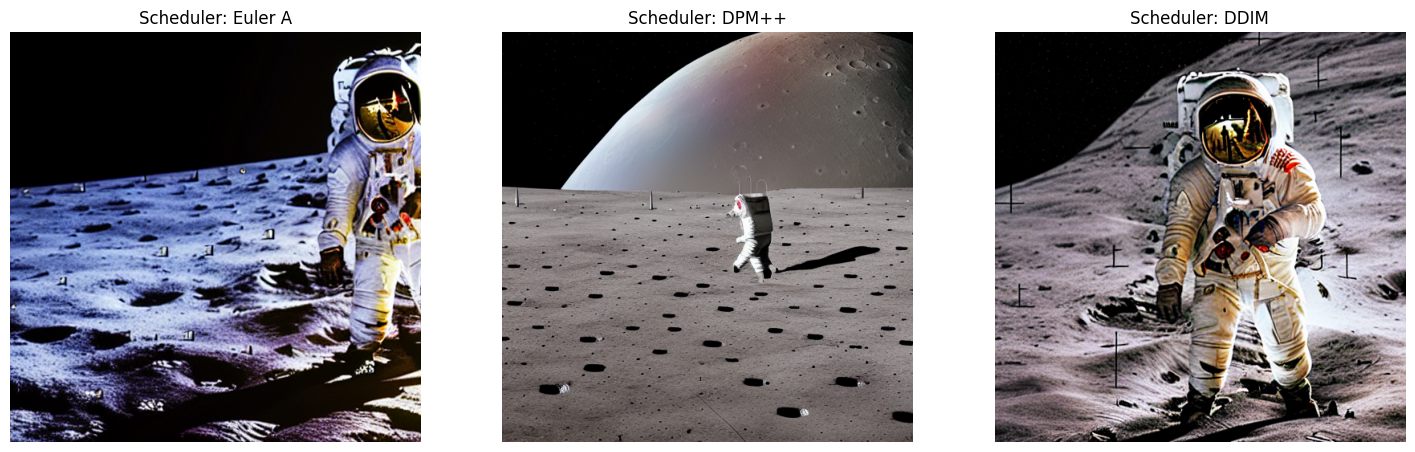

In [9]:
from diffusers import EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler, DDIMScheduler
import matplotlib.pyplot as plt

# 1. Siapkan Parameter Dasar
prompt = "an astronaut on the moon with planet earth visible in the background, highly detailed, realistic, 8k resolution"
seed = 222
num_steps = 30
images_sched = []

# 2. Daftar Scheduler yang akan diuji
schedulers = [
    ("Euler A", EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)),
    ("DPM++", DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)),
    ("DDIM", DDIMScheduler.from_config(pipe.scheduler.config))
]

# 3. Loop Generation untuk setiap Scheduler
for name, sched in schedulers:
    # Ganti scheduler pada pipeline
    pipe.scheduler = sched

    # Generate gambar
    img = pipe(
        prompt=prompt,
        num_inference_steps=num_steps,
        guidance_scale=7.5,
        generator=torch.Generator(device=pipe.device).manual_seed(seed)
    ).images[0]

    images_sched.append(img)

# 4. Visualisasi Berdampingan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axes):
    ax.imshow(images_sched[i])
    ax.set_title(f"Scheduler: {schedulers[i][0]}")
    ax.axis('off')
plt.show()

### **Scheduler Comparation:**

*   **Gambar dengan "Euler A Scheduler":**  
*Menghasilkan gambar dengan tekstur yang cenderung lebih lembut dan artistik. Scheduler ini bersifat ancestral, yang berarti gambar bisa terus berubah secara subtil meskipun jumlah step ditambah sangat tinggi. Biasanya memberikan hasil yang bagus dalam waktu singkat (step rendah).*

*   **Gambar dengan "DPM++ Scheduler":**  
*Dikenal sebagai salah satu scheduler tercepat dan paling efisien saat ini. Gambar yang dihasilkan biasanya memiliki detail yang sangat tajam dan konvergen (stabil) lebih cepat daripada Euler A, sehingga sering menjadi pilihan utama untuk kualitas fotorealistik.*

*   **Gambar dengan "DDIM Scheduler":**  
*Merupakan scheduler klasik yang bersifat deterministik. Keunggulannya adalah stabilitas tinggi dan kemampuannya untuk melakukan inversion (penting untuk teknik editing gambar tingkat lanjut). Hasilnya cenderung konsisten namun terkadang membutuhkan lebih banyak step untuk menyamai ketajaman DPM++.*

# **Kriteria 2: Menyempurnakan Gambar Melalui Image-to-Image**

## **Base + Refiner Image Generation**


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/30 [00:00<?, ?it/s]

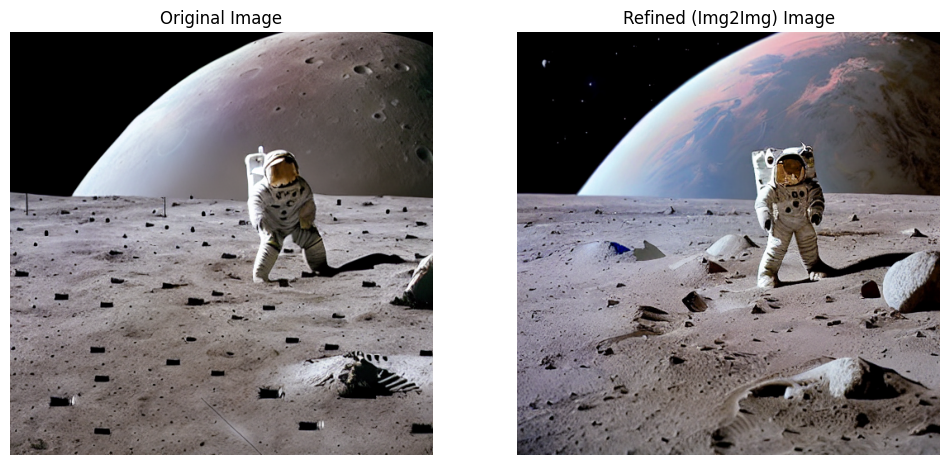

In [10]:
from diffusers import StableDiffusionImg2ImgPipeline
import torch

# 1. Load Pipeline khusus Image-to-Image
# Kita bisa menggunakan model yang sama (v1-5)
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

# 2. Siapkan Gambar Input (Gunakan gambar astronot dari langkah sebelumnya)
# Pastikan variabel 'image' dari Kriteria 1 masih ada di memori
init_image = image.convert("RGB").resize((512, 512))

# 3. Tentukan Prompt untuk Modifikasi
prompt = "A majestic astronaut in a golden suit, fantasy style, oil painting"
negative_prompt = "blurry, low quality"

# 4. Generate dengan Image-to-Image
# strength: 0.0 (gambar asli) sampai 1.0 (gambar berubah total)
refined_image = pipe_img2img(
    prompt=prompt,
    image=init_image,
    strength=0.6,
    guidance_scale=7.5,
    negative_prompt=negative_prompt
).images[0]

# 5. Tampilkan Perbandingan
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(init_image)
ax[0].set_title("Original Image")
ax[1].imshow(refined_image)
ax[1].set_title("Refined (Img2Img) Image")
for a in ax: a.axis('off')
plt.show()

## **Inpainting**

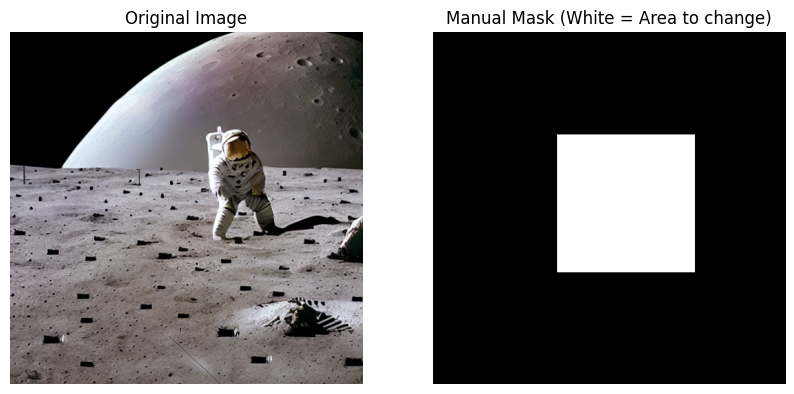

  0%|          | 0/50 [00:00<?, ?it/s]

In [11]:
def inpaint_engine(image, mask, prompt):
    # Ensure images are in RGB/L mode and correct size
    init_image = image.convert("RGB").resize((512, 512))
    mask_image = mask.convert("L").resize((512, 512))
    
    # Use global pipe_inpaint
    res = pipe_inpaint(
        prompt=prompt,
        image=init_image,
        mask_image=mask_image,
        negative_prompt="photorealistic, realistic, photograph, 3d render, messy, blurry, low quality, bad art, ugly, sketch, grainy, unfinished, chromatic aberration",
        num_inference_steps=30,
        guidance_scale=7.5
    ).images[0]
    return res

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 1. Gunakan gambar hasil generate sebelumnya sebagai base
init_image = image.convert("RGB").resize((512, 512))

# 2. Membuat Mask Manual (Broken Satellite Area)
mask_array = np.zeros((512, 512), dtype=np.uint8)
mask_array[100:300, 250:450] = 255
mask_image = Image.fromarray(mask_array)

# Tampilkan gambar dasar dan mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(init_image)
ax[0].set_title("Original Image")
ax[1].imshow(mask_image, cmap='gray')
ax[1].set_title("Manual Mask")
for a in ax: a.axis('off')
plt.show()

# 3. Generate dengan prompt 'broken satellite'
prompt = "a broken satellite floating in space, detailed debris, cinematic, space background"
result = inpaint_engine(init_image, mask_image, prompt)

plt.imshow(result)
plt.title("Inpainting Result: Broken Satellite")
plt.axis('off')
plt.show()

## **Inpainting Menggunakan Automasking**

### **load Model Segmentation Untuk Masking**

In [13]:
from transformers import pipeline

# Perbaikan nama model: hapus angka 150
# Model ini akan mendeteksi objek berdasarkan dataset ADE20K
segmenter = pipeline("image-segmentation", model="nvidia/segformer-b0-finetuned-ade-512-512")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

The image processor of type `SegformerImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


### **Masking with Segmentation Model**

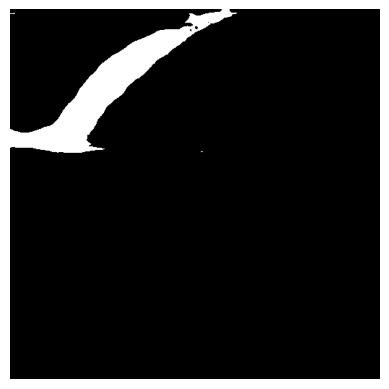

In [14]:
# Ambil gambar hasil generate sebelumnya (pastikan variabel 'image' sudah ada)
init_image = image.convert("RGB").resize((512, 512))
segments = segmenter(init_image)

# Pilih objek 'sky' (langit) untuk diganti secara otomatis
target_label = "sky"
auto_mask = next((s['mask'] for s in segments if s['label'] == target_label), segments[0]['mask'])

plt.imshow(auto_mask, cmap='gray')
plt.axis('off')
plt.show()

### **Generate**

In [15]:
# Generate menggunakan auto_mask dari segmentation model
prompt = "a majestic space galaxy, nebula clouds, highly detailed, cinematic"
result = inpaint_engine(init_image, auto_mask, prompt)

plt.figure(figsize=(8, 8))
plt.imshow(result)
plt.title("Inpainting Result: Auto-Masking")
plt.axis('off')
plt.show()

## **Outpainting**

### **Prepare the Canvas**

In [ ]:
def prepare_outpainting(image, direction, expand_pixels=128):
    """
    Melakukan perluasan kanvas ke satu arah tertentu.
    direction: 'left', 'right', 'up', 'down'
    """
    init_image = image.convert("RGB").resize((512, 512))
    w, h = init_image.size
    
    if direction == "left":
        new_size = (w + expand_pixels, h)
        paste_pos = (expand_pixels, 0)
        mask_box = (0, 0, expand_pixels, h)
    elif direction == "right":
        new_size = (w + expand_pixels, h)
        paste_pos = (0, 0)
        mask_box = (w, 0, w + expand_pixels, h)
    elif direction == "up":
        new_size = (w, h + expand_pixels)
        paste_pos = (0, expand_pixels)
        mask_box = (0, 0, w, expand_pixels)
    elif direction == "down":
        new_size = (w, h + expand_pixels)
        paste_pos = (0, 0)
        mask_box = (0, h, w, h + expand_pixels)
    else:
        raise ValueError("Direction must be left, right, up, or down")

    canvas = Image.new("RGB", new_size, (128, 128, 128))
    canvas.paste(init_image, paste_pos)
    
    mask = Image.new("L", new_size, 0)
    from PIL import ImageDraw
    draw = ImageDraw.Draw(mask)
    draw.rectangle(mask_box, fill=255)
    
    return canvas, mask

# Contoh: expands to the right
outpaint_canvas, outpaint_mask = prepare_outpainting(image, direction="right", expand_pixels=256)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(outpaint_canvas)
ax[0].set_title("Outpaint Canvas (Right Expansion)")
ax[1].imshow(outpaint_mask, cmap='gray')
ax[1].set_title("Outpaint Mask")
for a in ax: a.axis('off')
plt.show()

### **Generate**

In [ ]:
# Resize ke 512x512 kembali untuk model
canvas_resized = outpaint_canvas.resize((512, 512))
mask_resized = outpaint_mask.resize((512, 512))

prompt = "A vast lunar landscape, stars and space nebula, cinematic, high resolution"

outpainted_result = inpaint_engine(canvas_resized, mask_resized, prompt)

plt.figure(figsize=(8, 8))
plt.imshow(outpainted_result)
plt.title("Outpainting Result")
plt.axis('off')
plt.show()

## **Outpainting Zoom Out**

### **Prepare Canvas for Zoom Out**

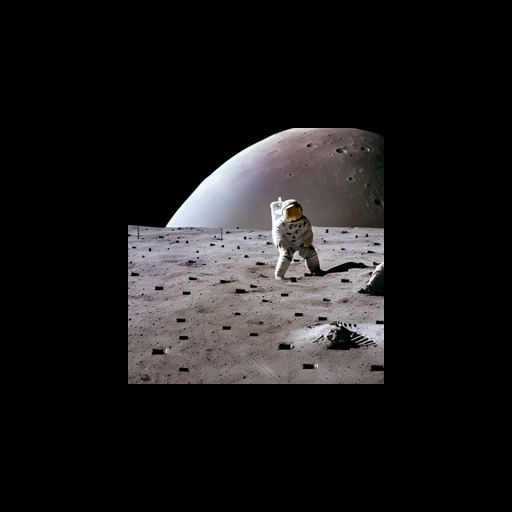

In [16]:
# 1. Perkecil gambar asli (Zoom Out)
zoom_scale = 0.5 # Kecilkan hingga 50%
smaller_image = init_image.resize((int(512 * zoom_scale), int(512 * zoom_scale)))

# 2. Buat kanvas 512x512 dan tempel gambar kecil di tengah
zoom_out_canvas = Image.new("RGB", (512, 512), (0, 0, 0))
offset = (512 - smaller_image.width) // 2
zoom_out_canvas.paste(smaller_image, (offset, offset))

# 3. Buat mask untuk area sekeliling gambar kecil
zoom_out_mask = Image.new("L", (512, 512), 255)
zoom_out_mask.paste(Image.new("L", smaller_image.size, 0), (offset, offset))

display(zoom_out_canvas)

### **Generate**

  0%|          | 0/30 [00:00<?, ?it/s]

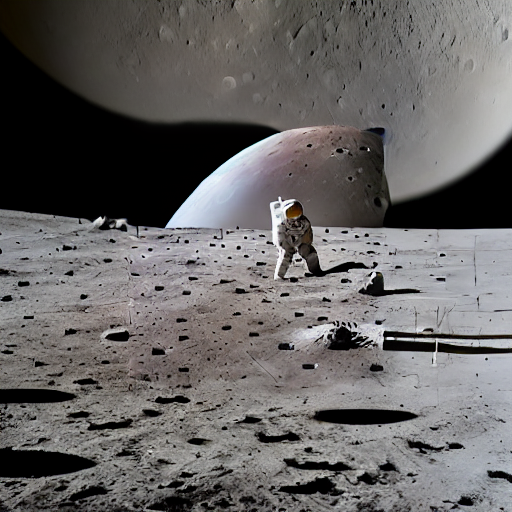

In [17]:
prompt = "full view of an astronaut standing on the moon, planet earth in the distance, wide shot, masterpiece"

zoom_out_result = pipe_inpaint(
    prompt=prompt,
    image=zoom_out_canvas,
    mask_image=zoom_out_mask,
    num_inference_steps=30
).images[0]

display(zoom_out_result)